# EDA table data

In [1]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import catboost

import metrics
import metadata_preprocessing

In [2]:
TRAIN_DATA_PATH = r'data/input/train.parquet'
TEST_DATA_PATH = r'data/input/test.parquet'

In [3]:
data_train = pd.read_parquet(TRAIN_DATA_PATH, engine="pyarrow")
data_test = pd.read_parquet(TEST_DATA_PATH, engine="pyarrow")

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312908 entries, 0 to 312907
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   item_id           312908 non-null  int64  
 1   order_date        312908 non-null  object 
 2   item_condition    296614 non-null  object 
 3   item_price        312908 non-null  float64
 4   category_name     312908 non-null  object 
 5   subcategory_name  312908 non-null  object 
 6   microcat_name     312908 non-null  object 
 7   seller_id         312908 non-null  int64  
 8   buyer_id          312908 non-null  int64  
 9   title             312908 non-null  object 
 10  description       312908 non-null  object 
 11  image_name        312908 non-null  object 
 12  real_weight       312908 non-null  float64
 13  real_height       312908 non-null  float64
 14  real_length       312908 non-null  float64
 15  real_width        312908 non-null  float64
dtypes: float64(5), int64

# Выбросы/ошибки в данных и поиск дупликатов

In [5]:
heavy_weights = data_train.nlargest(100, 'real_weight')
heavy_weights

,item_id,order_date,item_condition,item_price,category_name,subcategory_name,microcat_name,seller_id,buyer_id,title,description,image_name,real_weight,real_height,real_length,real_width
8337,139419,2024-07-10,Б/у,5000.0,Транспорт,Запчасти и аксессуары,Электрооборудование,487099,514504,Проводка Peugeot 206 1.6,Проводка Peugeot 206 1.6 2007г\n\n трёхдверный...,139419.jpg,7090.00,35.0,50.0,40.0
45302,1413997,2024-07-13,Б/у,1500.0,Электроника,Аудио и видео,"Акустика, колонки, сабвуферы",1186113,1371196,Аудиосистема Microlab M-200вт,Аудиосистема Microlab M-200вт. В рабочем состо...,1413997.jpg,4555.00,30.0,35.0,35.0
244562,148210,2024-01-31,Новое,3100.0,Для дома и дачи,Мебель и интерьер,Постельное бельё,2004742,2324580,Постельное бельё с одеялом евро,🌺Постельное белье с одеялом и простынью на ре...,148210.jpg,3250.00,13.0,50.0,40.0
232180,1475743,2024-06-18,Новое,750.0,Для дома и дачи,Ремонт и строительство,Водоочистка и фильтры,1841643,1258887,Жидкость для биотуалета Тhetford,Жидкость Thetford для биотуалета. для верхнег...,1475743.jpg,3000.00,10.0,10.0,10.0
232709,458921,2024-02-07,Б/у,200.0,Личные вещи,Детская одежда и обувь,Комбинезоны,1961529,2217273,Одежда пакетом 68 размер (забронировали),Отдам одежду для девочки\nБесплатно при самовы...,458921.jpg,2740.00,30.0,40.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168102,1380261,2024-06-26,Б/у,14300.0,Электроника,Товары для компьютера,Корпуса,74010,1905798,Корпус чёрный lian LI PC-O11 Dynamic XL ROG Ce...,"Целый, всё как с завода, даже осталась плёнка ...",1380261.jpg,27.50,38.0,60.0,60.0
138340,1215755,2024-06-02,Б/у,28000.0,Для дома и дачи,Ремонт и строительство,Пилы и лобзики,1194699,1400945,"Маятниковая, торцовочная пила","Маятниковая, торцовочная пила virutex tm73c.\n...",1215755.jpg,27.44,40.0,70.0,50.0
159062,868159,2024-03-14,Б/у,10000.0,Транспорт,Запчасти и аксессуары,Двигатель,1849410,814793,Головка блока форд фокус 1,"Головка блока на форд фокус 1. 1,8",868159.jpg,27.24,32.0,85.0,49.0
239386,220579,2024-06-29,Новое,20000.0,Для дома и дачи,Бытовая техника,Вентиляторы,501850,1733793,Вентиляторы ziehl abegg,Вентиляторы осевые для конденсаторных блоков. ...,220579.jpg,27.00,55.0,57.0,55.0


In [6]:
highest = data_train.nlargest(100, 'real_height')
highest

,item_id,order_date,item_condition,item_price,category_name,subcategory_name,microcat_name,seller_id,buyer_id,title,description,image_name,real_weight,real_height,real_length,real_width
95915,1675102,2024-08-19,Б/у,100.0,Для дома и дачи,Посуда и товары для кухни,Товары для кухни,2178921,2391516,Хоз товары и тряпки,"Хоз товары, тряпки",1675102.jpg,15.81,288.0,437.0,321.0
34669,1088814,2024-03-28,Б/у,800.0,Электроника,Фототехника,Оборудование и аксессуары,422671,1949683,Цифровая фоторамка view sonic,"Модель VFМ1036w-11Е\nВ хорошем состоянии, почт...",1088814.jpg,1.81,153.0,333.0,253.0
197162,1661424,2024-11-12,Б/у,5400.0,Электроника,Оргтехника и расходники,"МФУ, копиры и сканеры",1093475,30370,Мфу лазерный Ricoh sp220 snw,"Хорошее рабочее состояние, без дефектов! Новый...",1661424.jpg,38.22,135.0,162.0,138.0
249173,1875634,2024-10-27,Б/у,9500.0,Для дома и дачи,Бытовая техника,Очистители воздуха,1153747,267046,Мойка воздуха Venta lw15,Увлажнитель - мойка воздуха venta lw15. В отли...,1875634.jpg,11.07,108.0,150.0,120.0
3356,1811683,2024-11-15,Новое с биркой,2500.0,Личные вещи,"Одежда, обувь, аксессуары",Топы и футболки,883685,833017,Karl lagerfeld топ оригинал,Топ новый с биркой.\n\nРазмер в наличии s идёт...,1811683.jpg,0.60,105.0,150.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171809,459609,2024-02-21,Б/у,5600.0,Хобби и отдых,Велосипеды,Запчасти и аксессуары,856782,49191,"Ободa 27, 5 Racе Fасе аr24","Обода 27,5 дюймов. Racе Fасе АR24, Ширинa: вну...",459609.jpg,1.60,67.0,67.0,67.0
235922,954914,2024-03-02,Б/у,5500.0,Хобби и отдых,Велосипеды,Запчасти и аксессуары,1972718,587534,Рама от велосипеда,"Продам раму от велика, колёс нет.",954914.jpg,12.30,67.0,120.0,120.0
260140,880295,2024-04-18,Б/у,1300.0,Транспорт,Запчасти и аксессуары,Система охлаждения,133286,1139456,Вентилятор радиатора Opel Omega B Y22DTH,Вентилятор радиатора Opel Omega B Y22DTH (б/у)...,880295.jpg,4.55,67.0,77.0,77.0
8814,1646916,2024-11-13,Б/у,3300.0,Электроника,Аудио и видео,"Музыкальные центры, магнитолы",558807,148607,Магнитола Sharp WQ-261H(BL),Sharp WQ-261H(BL) - винтажная японская магнито...,1646916.jpg,10.20,66.0,171.0,69.0


In [7]:
longest = data_train.nlargest(100, 'real_length')
longest

,item_id,order_date,item_condition,item_price,category_name,subcategory_name,microcat_name,seller_id,buyer_id,title,description,image_name,real_weight,real_height,real_length,real_width
37315,1099165,2024-05-28,Б/у,2000.0,Электроника,Фототехника,Зеркальные фотоаппараты,1145987,891526,Тушка Canon 1000d,"Тушка canon 1000d, работает отлично, состояние...",1099165.jpg,0.850,16.0,111363.0,28.0
180033,216891,2024-01-11,None,370.0,Личные вещи,Красота и здоровье,Средства для волос,1345411,1467631,Schwarzkopf professional Кондиционер для волос,Кондиционер для волос PEPTIDE REPAIR rescue дл...,216891.jpg,0.560,1.0,21789.0,11029.0
77757,1686069,2024-08-23,Хорошее,30.0,Личные вещи,"Одежда, обувь, аксессуары",Сумки,534652,1523587,Отправлено Большая сумка женской обуви,"Продаю свою обувь: сапоги ботильоны, туфли и т...",1686069.jpg,12.900,30.0,7010.0,33.0
5264,618796,2024-01-21,Б/у,635.0,Хобби и отдых,Книги и журналы,Учебная литература,26525,1750451,"Учебник английского языка 1, 2, 3 класс технол...","Продаются учебники английского языка для 1, 2 ...",618796.jpg,1.075,3.0,3023.0,23.0
144014,683384,2024-01-13,Б/у,300.0,Хобби и отдых,Книги и журналы,Книги,492168,286503,"Кролик, который хочет уснуть",Книга в идеальным состоянии.\n\nВ профиле есть...,683384.jpg,0.476,6.0,2015.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298999,484634,2024-02-10,Новое,1000.0,Транспорт,Запчасти и аксессуары,Кузов,2285962,978197,Решетка радиатора Ford Transit 94-96,Новая.\n\nМагазин автозапчастей для автомобиле...,484634.jpg,2.400,15.0,193.0,25.0
308366,464071,2024-02-01,Новое,1500.0,Транспорт,Запчасти и аксессуары,Защита и декор,1324627,1190817,Накладки на пороги kia spectra 2 шт,Продаю накладки на пороги на kia spectra \nНов...,464071.jpg,1.000,10.0,192.0,17.0
22299,644997,2024-02-26,Б/у,16000.0,Транспорт,Запчасти и аксессуары,Тюнинг,570068,727745,Подножки lexus LX 470,Продам подножки Lexus LX470. Оригинальные. Сос...,644997.jpg,16.500,20.0,190.0,30.0
40338,1120868,2024-08-09,Б/у,2556.0,Транспорт,Запчасти и аксессуары,Кузов,2045570,258139,Накладка на порог правая (Subaru Outback),[арт. 515664] Накладка на порог правая\nСостоя...,1120868.jpg,1.000,8.0,190.0,15.0


In [8]:
widthest = data_train.nlargest(10, 'real_width')
widthest

,item_id,order_date,item_condition,item_price,category_name,subcategory_name,microcat_name,seller_id,buyer_id,title,description,image_name,real_weight,real_height,real_length,real_width
180033,216891,2024-01-11,None,370.0,Личные вещи,Красота и здоровье,Средства для волос,1345411,1467631,Schwarzkopf professional Кондиционер для волос,Кондиционер для волос PEPTIDE REPAIR rescue дл...,216891.jpg,0.560,1.0,21789.0,11029.0
267680,961397,2024-05-23,Б/у,5300.0,Транспорт,Запчасти и аксессуары,Тормозная система,371963,1165394,Диск тормозной ауди Q7 4M 4M0615301AB перед,4M0615301AB\r\nОРИГИНАЛЬНЫЙ 100%!\r\nMade in G...,961397.jpg,23.800,14.0,365.0,365.0
95915,1675102,2024-08-19,Б/у,100.0,Для дома и дачи,Посуда и товары для кухни,Товары для кухни,2178921,2391516,Хоз товары и тряпки,"Хоз товары, тряпки",1675102.jpg,15.810,288.0,437.0,321.0
34669,1088814,2024-03-28,Б/у,800.0,Электроника,Фототехника,Оборудование и аксессуары,422671,1949683,Цифровая фоторамка view sonic,"Модель VFМ1036w-11Е\nВ хорошем состоянии, почт...",1088814.jpg,1.810,153.0,333.0,253.0
240024,1836483,2024-10-23,Б/у,5000.0,Личные вещи,Товары для детей и игрушки,Куклы и аксессуары,538886,348581,Дом мечты барби,"В идеальном состоянии, в комплекте куча мебели...",1836483.jpg,39.000,66.0,225.0,225.0
307037,1745944,2024-10-26,Б/у,540.0,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,1400307,934415,Матрас для детей 120 60,Матрасик \nПользовались 3-4 Месяца. \n120*60,1745944.jpg,3.000,30.0,330.0,174.0
46306,993462,2024-11-12,Новый,9190.0,Личные вещи,Товары для детей и игрушки,Конструкторы,206224,413127,Конструктор playmobil 9462 City Action Пожарна...,"Уценка, нетоварный вид коробки\n\nДаже в самом...",993462.jpg,10.362,33.0,198.0,165.0
286287,1884059,2024-10-28,Б/у,3500.0,Хобби и отдых,Спорт и отдых,Настольные игры,1372519,22841,Подставка для настольного хоккея stiga,"Подставка для хоккея Stiga, есть регулировка п...",1884059.jpg,11.700,21.0,285.0,156.0
26994,1945107,2024-11-13,Б/у,600.0,Личные вещи,Товары для детей и игрушки,Товары для купания,1100433,2044165,Ванночка для купания складная с гамаком,"Бронь! \n\nПродаю складную детскую ванну, с га...",1945107.jpg,6.300,18.0,228.0,150.0
128092,1648352,2024-10-20,Б/у,1200.0,Транспорт,Запчасти и аксессуары,Автосвет,315110,1777629,Фара правая Ford Fiesta MK6 (08-17),Продается правая фара на Ford Fiesta MK6 крепл...,1648352.jpg,12.720,81.0,201.0,141.0


In [9]:
data_train = metadata_preprocessing.drop_outliners(data_train)

In [10]:
print(f'Количество данных: {len(data_train)}')
print(f'Количество уникальных данных: {len(data_train.item_id.unique())}')

Количество данных: 312623
Количество уникальных данных: 312623


# Пропуски в данных

<Axes: >

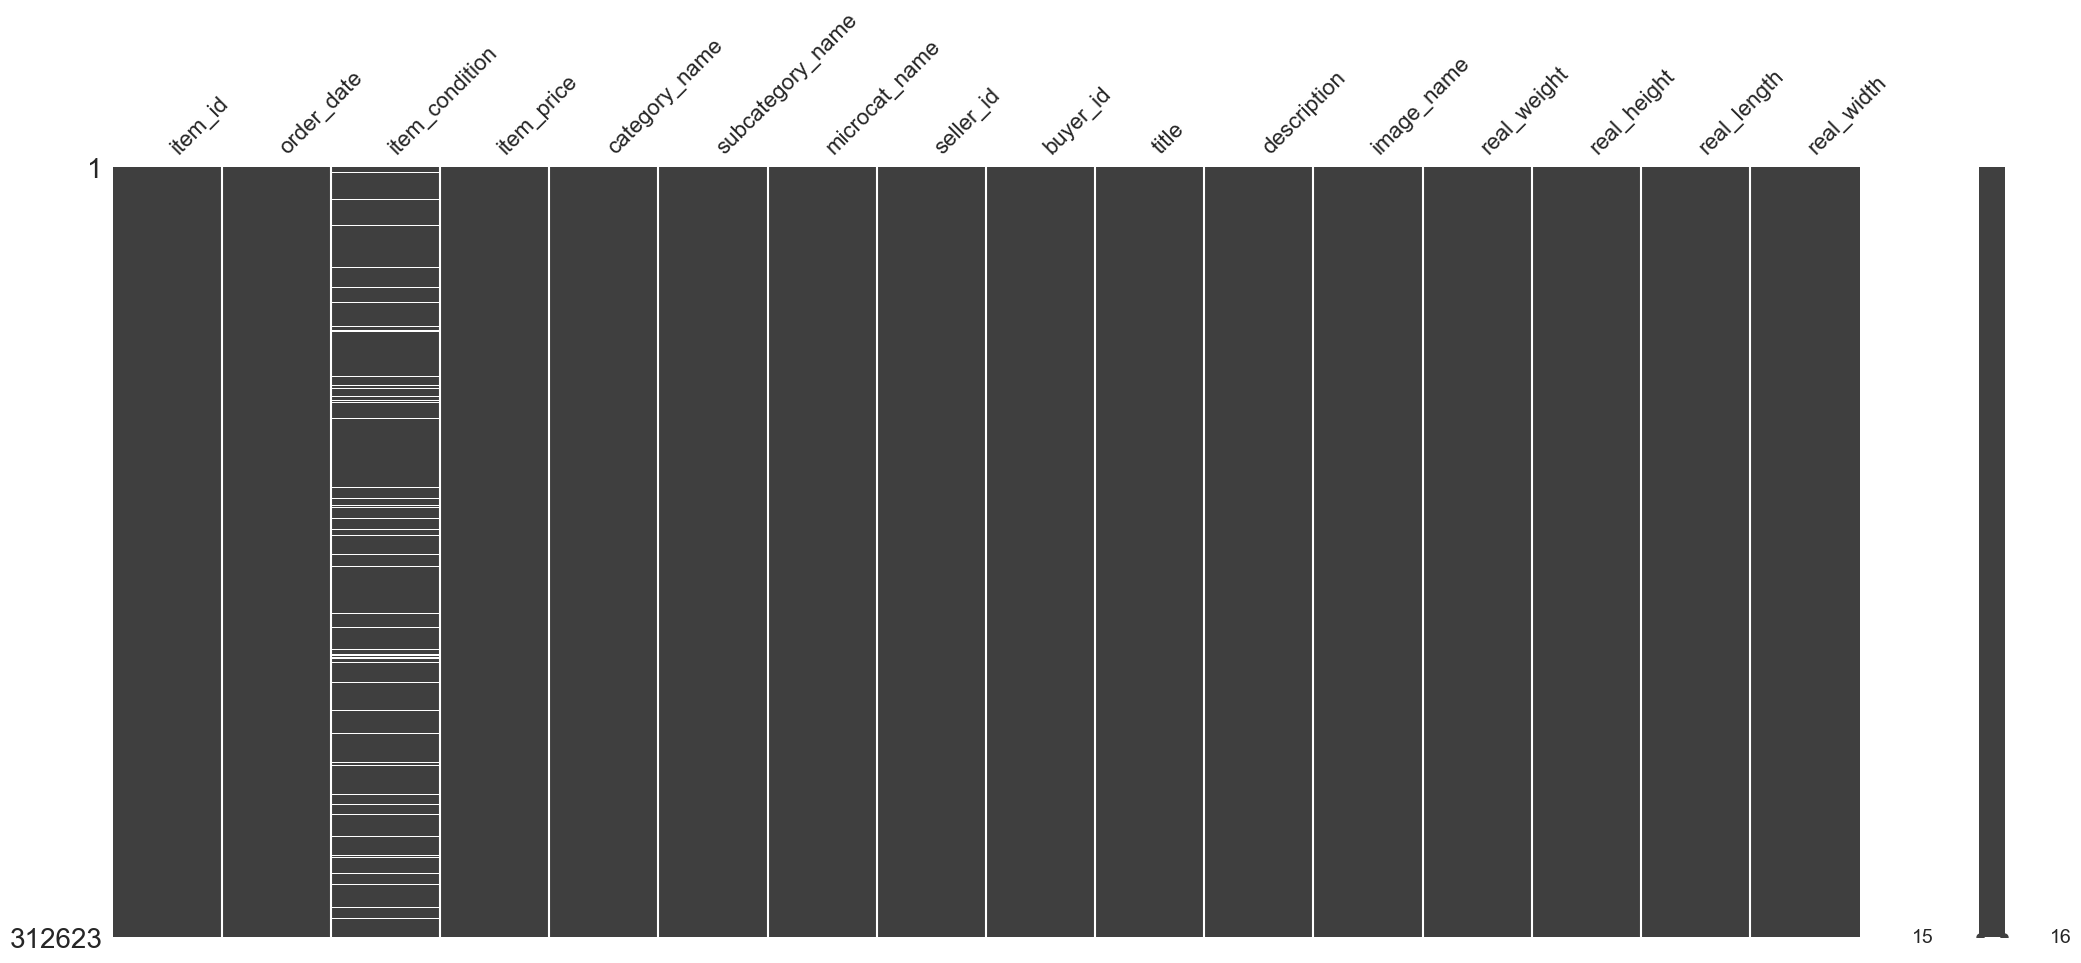

In [11]:
msno.matrix(data_train)

In [12]:
data_train.isna().sum() * 100 / len(data_train)

item_id             0.00000
order_date          0.00000
item_condition      5.20947
item_price          0.00000
category_name       0.00000
subcategory_name    0.00000
microcat_name       0.00000
seller_id           0.00000
buyer_id            0.00000
title               0.00000
description         0.00000
image_name          0.00000
real_weight         0.00000
real_height         0.00000
real_length         0.00000
real_width          0.00000
dtype: float64

In [13]:
data_train = metadata_preprocessing.nan_to_cat(data_train, 'item_condition')

In [14]:
data_train.item_condition.unique()

array(['Б/у', 'Новое с биркой', 'Новое', 'Отличное', 'no_info', 'Хорошее',
       'Новый', 'Как новое', 'Удовлетворительное'], dtype=object)

In [15]:
data_train.groupby(['item_condition'])[['real_weight', 'real_height', 'real_length', 'real_width']].mean()

,real_weight,real_height,real_length,real_width
item_condition,,,,
no_info,0.683878,10.659217,22.608805,17.004298
Б/у,1.900512,12.731603,33.426216,23.653287
Как новое,0.919239,11.122216,30.639634,22.735009
Новое,1.747263,11.648135,31.641878,21.790592
Новое с биркой,1.009078,9.887210,33.703827,25.261838
Новый,0.940249,9.854475,31.190797,23.263838
Отличное,0.911151,9.339762,33.541673,25.346294
Удовлетворительное,2.036989,13.637640,35.301030,26.084270
Хорошее,1.183478,11.162954,34.110826,25.522278


(-0.1, 40.0)

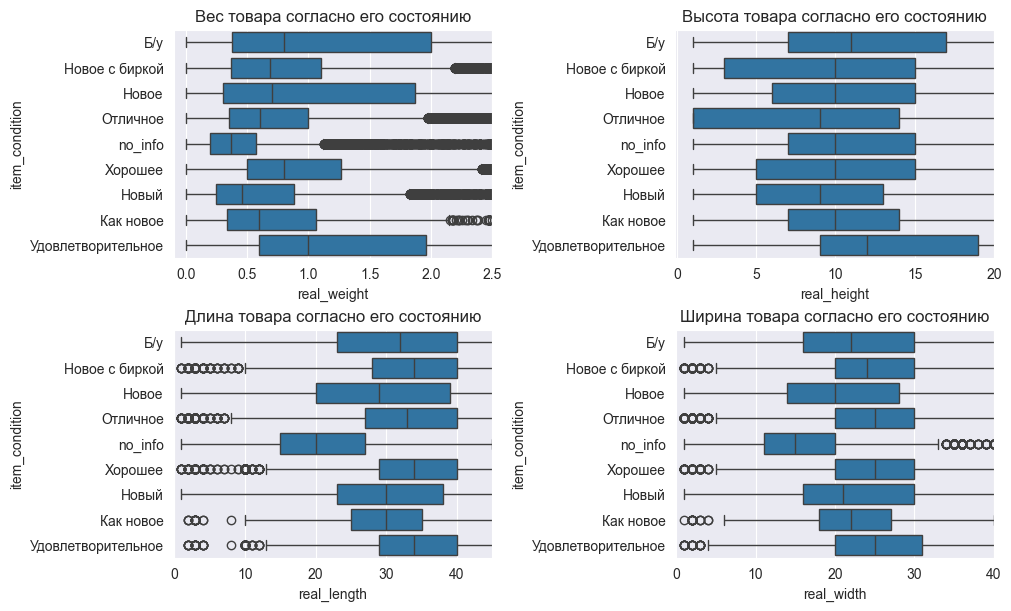

In [16]:
fg, axes = plt.subplots(2, 2, constrained_layout=True)

fg.set_size_inches(10, 6)

violins_weight = sns.boxplot(data=data_train, x='real_weight', y='item_condition', legend=False, ax=axes[0, 0])
axes[0, 0].set_title('Вес товара согласно его состоянию')
axes[0, 0].set_xlim(-0.1, 2.5)

violins_height = sns.boxplot(data=data_train, x='real_height', y='item_condition', legend=False, ax=axes[0, 1])
axes[0, 1].set_title('Высота товара согласно его состоянию')
axes[0, 1].set_xlim(-0.1, 20)

violins_length = sns.boxplot(data=data_train, x='real_length', y='item_condition', legend=False, ax=axes[1, 0])
axes[1, 0].set_title('Длина товара согласно его состоянию')
axes[1, 0].set_xlim(-0.1, 45)

violins_width = sns.boxplot(data=data_train, x='real_width', y='item_condition', legend=False, ax=axes[1, 1])
axes[1, 1].set_title('Ширина товара согласно его состоянию')
axes[1, 1].set_xlim(-0.1, 40)

# Дата и время

In [17]:
data_train['order_date'] = pd.to_datetime(data_train['order_date'], errors='coerce')
data_train['month_of_purchase'] = data_train['order_date'].dt.month

data_train.groupby(['month_of_purchase'])[['real_weight', 'real_height', 'real_width', 'real_height']].median()


,real_weight,real_height,real_width,real_height
month_of_purchase,,,,
1,0.70,10.0,24.0,10.0
2,0.69,10.0,24.0,10.0
3,0.70,10.0,24.0,10.0
4,0.68,10.0,22.0,10.0
5,0.61,10.0,21.0,10.0
6,0.60,10.0,20.0,10.0
7,0.60,10.0,20.0,10.0
8,0.65,10.0,21.0,10.0
9,0.70,10.0,21.0,10.0


(-0.1, 2.0)

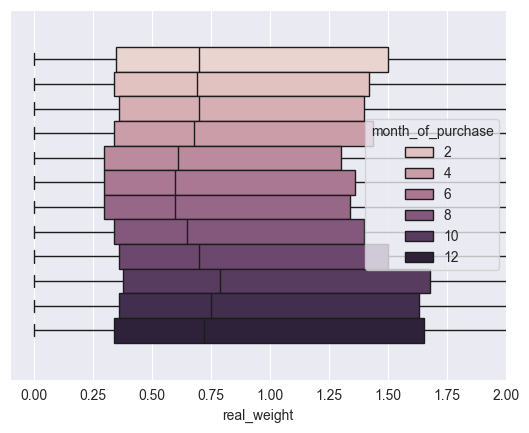

In [18]:
bxplt = sns.boxplot(data_train, x='real_weight', hue='month_of_purchase')
bxplt.set_xlim(-0.1, 2)

In [19]:
data_train = metadata_preprocessing.cyclic_encoding(data_train)

# Кодирование категориальных данных

In [20]:
print(f'Кол-во категорий {len(data_train.category_name.unique())}')
print(f'Кол-во субкатегорий {len(data_train.subcategory_name.unique())}')
print(f'Кол-во микрокатегорий {len(data_train.microcat_name.unique())}')
print('='*100)

Кол-во категорий 5
Кол-во субкатегорий 25
Кол-во микрокатегорий 359


In [21]:
cats_to_drop = ['item_id', 'seller_id', 'buyer_id', 'image_name', 'title', 'description', 'image_name']
cat_cols = ['category_name', 'subcategory_name', 'microcat_name']
target_cols = ['real_weight', 'real_height', 'real_length', 'real_width']

In [22]:
target_df = data_train[target_cols]
feats_df = data_train.drop(target_cols, axis=1)

feats_df.drop(cats_to_drop, axis=1, inplace=True)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(feats_df, target_df, test_size=0.2, random_state=42)

In [24]:
multiple_target_encoder = metadata_preprocessing.MultiTargetEncoder(
    cat_cols=cat_cols,
    target_cols=target_cols,
    encoder_cls=TargetEncoder,
    encoder_params=dict(
        cv=5,
        target_type='continuous',
        shuffle=True)
)

In [25]:
multiple_target_encoder.fit(X_train, y_train)

,cat_cols,"['category_name', 'subcategory_name', ...]"
,target_cols,"['real_weight', 'real_height', ...]"
,encoder_cls,<class 'sklea...argetEncoder'>
,encoder_params,"{'cv': 5, 'shuffle': True, 'target_type': 'continuous'}"


In [26]:
transformed_train = multiple_target_encoder.transform(X_train)

In [27]:
condition_encoder = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['item_condition'])
    ],
    remainder='passthrough'
)

# Apply the transformations
transformed_train = condition_encoder.fit_transform(transformed_train)

In [28]:
transformed_test = multiple_target_encoder.transform(X_test)
transformed_test = condition_encoder.transform(transformed_test)

In [29]:
transformed_train.shape

(250098, 24)

# Базовые модели

## Ridge

In [30]:
ridge_param_grid = {
    'alpha': [0.1, 1, 5],
    "max_iter": [1500, 3000],
    'fit_intercept': [True, False],
}


ridge_model = GridSearchCV(
    estimator=Ridge(),
    param_grid=ridge_param_grid,
    cv=5,
    n_jobs=-1
)

In [31]:
ridge_model.fit(transformed_train, y_train)

,estimator,Ridge()
,param_grid,"{'alpha': [0.1, 1, ...], 'fit_intercept': [True, False], 'max_iter': [1500, 3000]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,5


In [32]:
ridge_pred = ridge_model.predict(transformed_test)
print(f'logmae macro ridge-модели: {metrics.logmae_macro(y_test, ridge_pred):.4f}')

logmae macro ridge-модели: 0.3921


## Random forest

In [33]:
rf_model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=40,
    max_features='sqrt',
)

In [34]:
rf_model.fit(transformed_train, y_train)

,n_estimators,1000
,criterion,'squared_error'
,max_depth,40
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [35]:
rf_pred = rf_model.predict(transformed_test)
print(f'logmae macro random forest: {metrics.logmae_macro(y_test, rf_pred):.4f}')


logmae macro random forest: 0.4049


## CatBoost

In [36]:
catboost_ft = catboost.CatBoostRegressor(
    iterations=300,
    loss_function='MultiRMSE'
)

grid = {
    'learning_rate': [0.1, 1],
    'depth': [4, 6]
}

In [37]:
catboost_ft.grid_search(grid, transformed_train, y_train)

0:	learn: 42.9992499	test: 42.9892092	best: 42.9892092 (0)	total: 243ms	remaining: 1m 12s
1:	learn: 39.6564472	test: 39.6431636	best: 39.6431636 (1)	total: 355ms	remaining: 52.9s
2:	learn: 36.7136002	test: 36.6977948	best: 36.6977948 (2)	total: 443ms	remaining: 43.8s
3:	learn: 34.1560140	test: 34.1388344	best: 34.1388344 (3)	total: 470ms	remaining: 34.7s
4:	learn: 31.9150319	test: 31.8948359	best: 31.8948359 (4)	total: 513ms	remaining: 30.3s
5:	learn: 29.9685877	test: 29.9474253	best: 29.9474253 (5)	total: 535ms	remaining: 26.2s
6:	learn: 28.3039921	test: 28.2818294	best: 28.2818294 (6)	total: 557ms	remaining: 23.3s
7:	learn: 26.8563510	test: 26.8343620	best: 26.8343620 (7)	total: 583ms	remaining: 21.3s
8:	learn: 25.6248741	test: 25.6040829	best: 25.6040829 (8)	total: 729ms	remaining: 23.6s
9:	learn: 24.5872336	test: 24.5665478	best: 24.5665478 (9)	total: 820ms	remaining: 23.8s
10:	learn: 23.6875169	test: 23.6687217	best: 23.6687217 (10)	total: 847ms	remaining: 22.3s
11:	learn: 22.9424

{'params': {'depth': 6, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
    

122:	learn: 18.7174491	test: 18.7518498	best: 18.7518498 (122)	total: 4.3s	remaining: 6.19s
123:	learn: 18.7162396	test: 18.7519769	best: 18.7518498 (122)	total: 4.33s	remaining: 6.15s
124:	learn: 18.7146567	test: 18.7514325	best: 18.7514325 (124)	total: 4.37s	remaining: 6.12s
125:	learn: 18.7133414	test: 18.7511329	best: 18.7511329 (125)	total: 4.4s	remaining: 6.08s
126:	learn: 18.7121336	test: 18.7508584	best: 18.7508584 (126)	total: 4.44s	remaining: 6.05s
127:	learn: 18.7103868	test: 18.7500648	best: 18.7500648 (127)	total: 4.48s	remaining: 6.02s
128:	learn: 18.7092908	test: 18.7491692	best: 18.7491692 (128)	total: 4.52s	remaining: 5.99s
129:	learn: 18.7074360	test: 18.7483671	best: 18.7483671 (129)	total: 4.55s	remaining: 5.96s
130:	learn: 18.7060676	test: 18.7481966	best: 18.7481966 (130)	total: 4.59s	remaining: 5.92s
131:	learn: 18.7042920	test: 18.7471691	best: 18.7471691 (131)	total: 4.63s	remaining: 5.89s
132:	learn: 18.7025194	test: 18.7462205	best: 18.7462205 (132)	total: 4.

In [38]:
cb_preds = catboost_ft.predict(transformed_test)
print(f'logmae macro catboost: {metrics.logmae_macro(y_test, cb_preds):.4f}')

logmae macro catboost: 0.3727
